To address the k-armed bandit problem https://en.wikipedia.org/wiki/Multi-armed_bandit

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import beta
from scipy.integrate import trapz
%matplotlib inline  

In [2]:
class Arm():
    def __init__(self, prob):
        self.prob = prob
        
    def pull(self):
        return np.random.choice([0,1], 1, p = [1 - self.prob, self.prob])[0]

class Bandit():
    def __init__(self, probs):
        self.arms = {k:Arm(v) for k,v in enumerate(probs)}
    
    def pull_arm(self, arm_id):
        return self.arms[arm_id].pull()

***The random approach*** - reference

In [3]:
#probs = [0.1, 0.05]
probs = [0.1, 0.05,0.08]
n = 3000
bandit = Bandit(probs)

data = [] 
for _ in range(n):
    arm = np.random.choice(list(range(len(probs))))
    data.append([arm, bandit.pull_arm(arm), _])

In [4]:
df = pd.DataFrame(data, columns=['arm', 'score', 'time'])

In [5]:
agg = df.groupby(['arm', 'time']).agg([len, np.sum])['score'].reset_index()

In [6]:
#total_numbers=agg.pivot('time', 'arm')['len'].fillna(0).cumsum()
#arms_trials=total_numbers.max()
#print(arms_trials)

In [7]:
#total_success=agg.pivot('time', 'arm')['sum'].fillna(0).cumsum() #the 1s

#arms_success=total_success.max()
#print(arms_success)


In [8]:
#arms_failures=arms_trials - arms_success
#print(arms_failures)

In [9]:
#x = np.linspace(0, 0.3, 100)
#arm1
#plt.plot(x, beta(arms_success[0],arms_failures[0]).pdf(x), lw=2,label='arm 1')
#arm2
#plt.plot(x, beta(arms_success[1],arms_failures[1]).pdf(x), lw=2, label='arm 2')
#plt.legend()

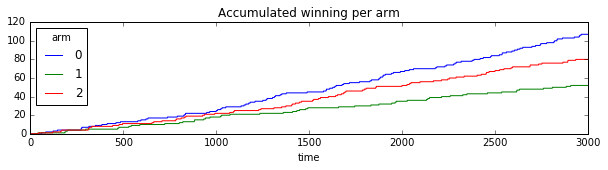

In [10]:
pltr = agg.pivot('time', 'arm')['sum'].fillna(0).cumsum()
pltr.plot(figsize=(10, 2), title = "Accumulated winning per arm")

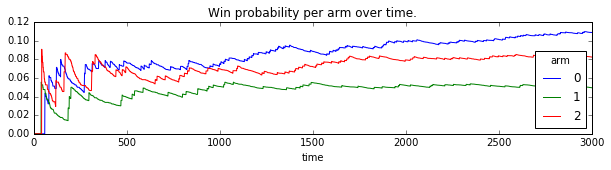

In [11]:
pltr = (pltr / agg.pivot('time', 'arm')['len'].fillna(0).cumsum())
_ = pltr.plot(figsize=(10, 2), title="Win probability per arm over time.")

In [12]:
total_profit = agg.pivot('time', 'arm')['sum'].cumsum().sum(axis = 1).max()
max_expected_profit = np.max(probs)*n
print("total profit is {}".format(total_profit))
print("total regret is {}".format(max_expected_profit - total_profit))

total profit is 107.0
total regret is 193.0


***Epsilon greedy strategy***

In [13]:
def pick_arm(counter, epsilon=0.05):
    if np.random.uniform() < epsilon:
        probs = [1.0 for _ in counter.keys()]
    else:
        probs = [(counter[_][0] + 0.001)/counter[_][1] for _ in counter.keys()]
    return np.random.choice(list(range(len(counter.keys()))), p = probs/np.sum(probs))

In [14]:
#probs = [0.1, 0.05]
probs = [0.1, 0.05,0.08]
n = 3000
bandit = Bandit(probs)
counter = {arm:(1,1) for arm in range(len(probs))}

data = []
for _ in range(n):
    arm = pick_arm(counter, 1/(_+1))
    outcome = bandit.pull_arm(arm)
    counter[arm] = counter[arm][0] + outcome, counter[arm][1] + 1
    data.append([arm, bandit.pull_arm(arm), _])


In [15]:
df = pd.DataFrame(data, columns=['arm', 'score', 'time'])
agg = df.groupby(['arm', 'time']).agg([len, np.sum])['score'].reset_index()

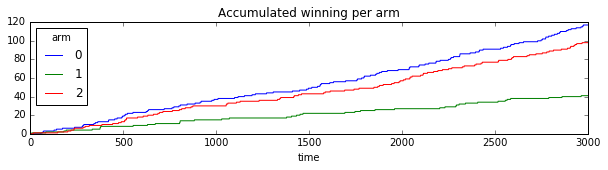

In [16]:
pltr = agg.pivot('time', 'arm')['sum'].fillna(0).cumsum()
_ = pltr.plot(figsize=(10, 2), title = "Accumulated winning per arm")

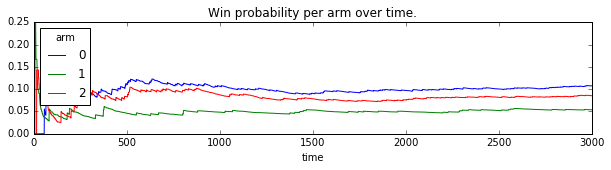

In [17]:
pltr = (pltr / agg.pivot('time', 'arm')['len'].fillna(0).cumsum())
_ = pltr.plot(figsize=(10, 2), title="Win probability per arm over time.")

In [18]:
total_profit = agg.pivot('time', 'arm')['sum'].cumsum().sum(axis = 1).max()
max_expected_profit = np.max(probs)*n
print("total profit is {}".format(total_profit))
print("total regret is {}".format(max_expected_profit - total_profit))

total profit is 117.0
total regret is 183.0


***Alternate solution (simple beta probabilities) - using belief ***

In [19]:
def convergence_decision_max_vs_min(counter):
    arm_betas=[]
    arm_means=[]
    x=np.linspace(0, 1, 1000)

    for key in counter.keys():
        current_arm = counter[key]

        arm_betas= arm_betas + [beta(current_arm[0],current_arm[1]-current_arm[0]).pdf(x)]

        arm_means.append(current_arm[0]/current_arm[1])

    arm_max_index = np.argmax(arm_means)
    arm_min_index = np.argmin(arm_means)
    arm_max = list(counter.keys())[arm_max_index]
    arm_min = list(counter.keys())[arm_min_index]

    mle_delta = arm_betas[arm_max_index]-arm_betas[arm_min_index]

    inflection_plus = np.where(mle_delta>0)
    inflection_minus = np.where(mle_delta<0)
    
    start_point_calc=0
    
    if((len(inflection_plus)>0)&(len(inflection_plus[0])>0)):
        start_point_calc=inflection_plus[0][0]
    
    if((len(inflection_minus)>0)&(len(inflection_minus[0])>0)):
        if(sum(inflection_plus[0]> max(inflection_minus[0]))>0):
            start_point_calc=inflection_plus[0][inflection_plus[0]> max(inflection_minus[0])][0]
        
    
    selected_x=x[start_point_calc:]
    selected_mle_delta = mle_delta[start_point_calc:]
    
    integral = trapz(selected_mle_delta,selected_x)
    return {'arm_max': arm_max, 'integral_max': integral,'arm_min':arm_min,'arm_max_means':arm_means[arm_max_index]}


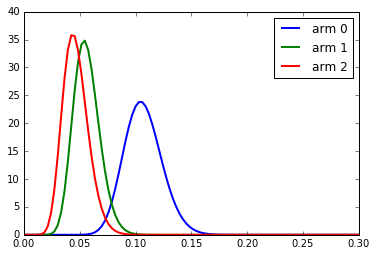

In [20]:
x = np.linspace(0, 0.3, 100)
#arm1
plt.plot(x, beta(36,301).pdf(x), lw=2,label='arm 0')
#arm2
plt.plot(x, beta(22,370).pdf(x), lw=2, label='arm 1')
plt.plot(x, beta(16,329).pdf(x), lw=2, label='arm 2')
plt.legend()

In [21]:
def pick_arm2(counter,accumulated_threshold, delta_prob_threshold,epsilon=0.05):
    

    if np.random.uniform() < epsilon:
        probs = [1.0 for _ in counter.keys()]            
    else:
        probs = [(counter[_][0] + 0.001)/counter[_][1] for _ in counter.keys()]

    probs=probs/np.sum(probs)
    
    if(sum([counter.get(x)[1] for x in counter.keys()])>accumulated_threshold):
        #if(sum([counter.get(x)[1] for x in counter.keys()]%50==0)):
        convergence= convergence_decision_max_vs_min(counter=counter)
            
        if((convergence.get('integral_max')>delta_prob_threshold)):
            probs=[(1-convergence.get('integral_max'))/float(len(counter)-1) for _ in counter.keys()]
            probs[convergence.get('arm_max')]=convergence.get('integral_max')
            
       
        
    #print(probs)        
    return np.random.choice(list(range(len(counter.keys()))), p = probs)

In [22]:
probs = [0.1, 0.05,0.08]
n = 3000
bandit = Bandit(probs)
counter = {arm:(1,1) for arm in range(len(probs))}

data = []
for _ in range(n):
    arm = pick_arm2(counter,200,0.8, 1/(_+1))
    outcome = bandit.pull_arm(arm)
  
    counter[arm] = counter[arm][0] + outcome, counter[arm][1] + 1
    data.append([arm, bandit.pull_arm(arm), _])

In [23]:
df = pd.DataFrame(data, columns=['arm', 'score', 'time'])

In [24]:
agg = df.groupby(['arm', 'time']).agg([len, np.sum])['score'].reset_index()

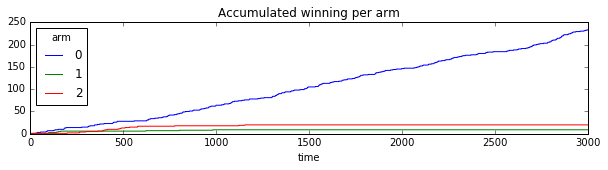

In [25]:
pltr = agg.pivot('time', 'arm')['sum'].fillna(0).cumsum()
_ = pltr.plot(figsize=(10, 2), title = "Accumulated winning per arm")

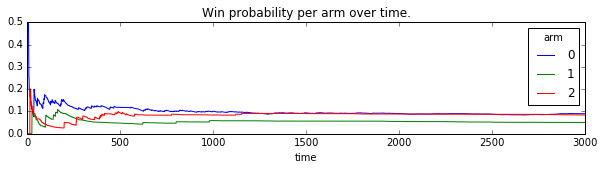

In [26]:
pltr = (pltr / agg.pivot('time', 'arm')['len'].fillna(0).cumsum())
_ = pltr.plot(figsize=(10, 2), title="Win probability per arm over time.")

In [27]:
total_profit = agg.pivot('time', 'arm')['sum'].cumsum().sum(axis = 1).max()
max_expected_profit = np.max(probs)*n
print("total profit is {}".format(total_profit))
print("total regret is {}".format(max_expected_profit - total_profit))

total profit is 233.0
total regret is 67.0
